In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
from wfdb import processing
import wfdb
import h5py
import scipy
import os
import glob

examples for loading data

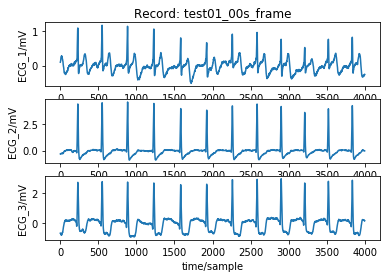

In [2]:
# Load the wfdb record and the physical samples
record = wfdb.rdrecord('sample-data/test01_00s_frame')
wfdb.plot_wfdb(record)

In [3]:
# Load the wfdb record and the physical samples
record = wfdb.rdrecord('sample-data/test01_00s_frame', smooth_frames=False)
display(record.e_p_signal)
print([len(s) for s in record.e_p_signal])

[array([ 0.1 ,  0.11,  0.13, ..., -0.27, -0.27, -0.26]),
 array([-0.08, -0.57, -0.06, ...,  0.13, -0.18,  0.12]),
 array([-0.66, -0.66, -0.67, ...,  0.15,  0.15,  0.16])]

[4000, 8000, 4000]


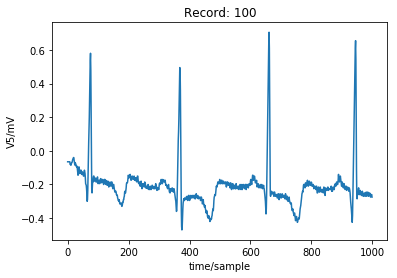

In [4]:
# Load the wfdb record and the physical samples
record = wfdb.rdrecord('sample-data/100', sampfrom=0, sampto=1000, channels=[1])
wfdb.plot_wfdb(record)

========================================================================================

LSTM based autoencoder

(1415, 1, 720)


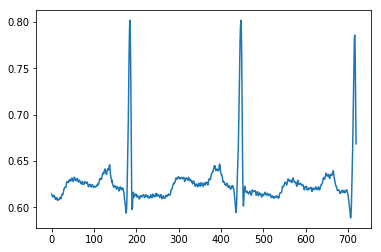

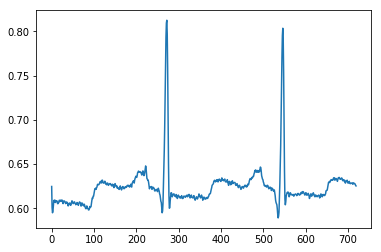

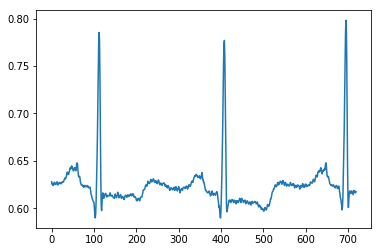

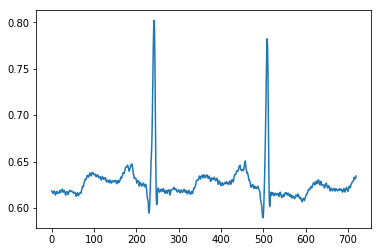

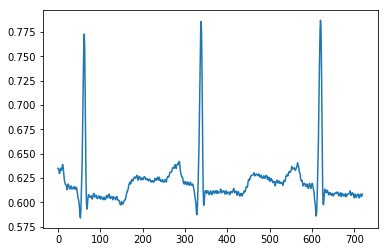

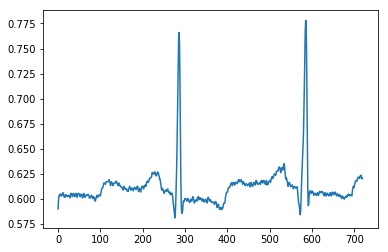

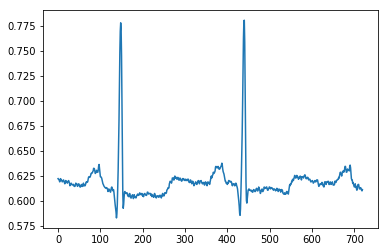

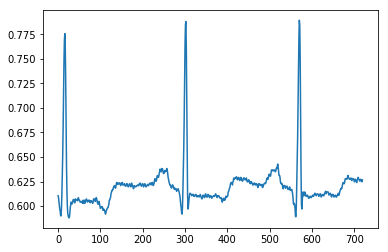

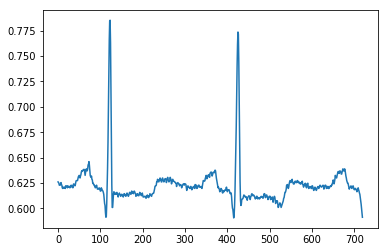

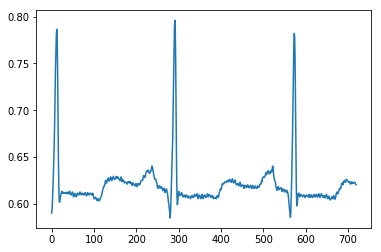

In [5]:
#arr = os.listdir('MLII/1 NSR/')
arr = []
for file in glob.glob('MLII/1 NSR/*.mat'):
    arr.append(file) 
#print (arr)   

arr = sorted(arr, key=lambda x:x[:])

l = 283
ll = 5
d = np.int(3600/ll)
stride = 1
data = []
for i in range(l):
    #print (arr[i])
    db = scipy.io.loadmat(arr[i])    
    for j in range(ll):
        data.append(db['val'][0, j*d:(j+1)*d])
data = np.array(data).reshape(l*ll, 1, d)    
seq_in = data[:, :, ::stride]
nr = np.amax(seq_in)
seq_in = seq_in/nr
print (seq_in.shape)  
for i in range(10):
    plt.figure()
    plt.plot(seq_in[i, 0, :])

10
(50, 1, 720)


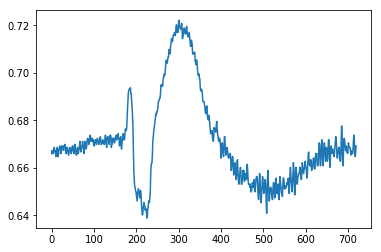

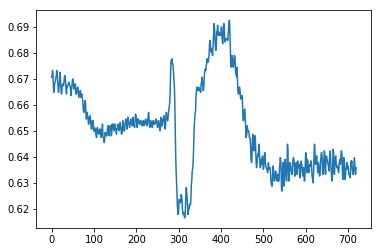

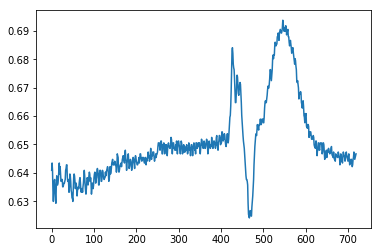

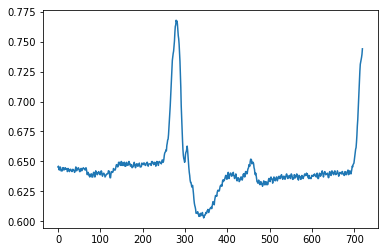

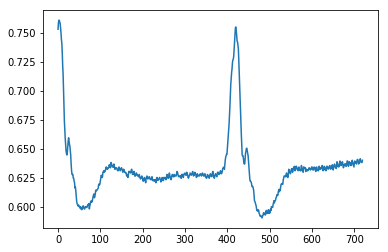

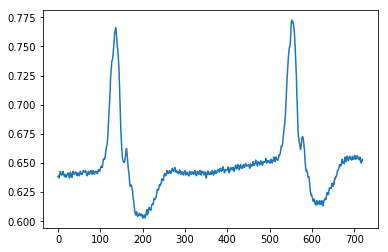

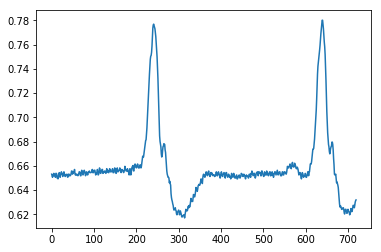

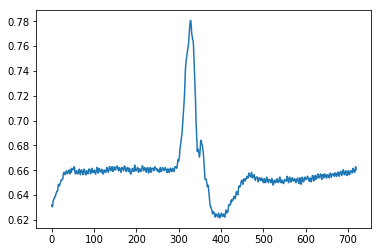

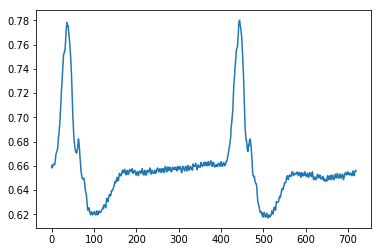

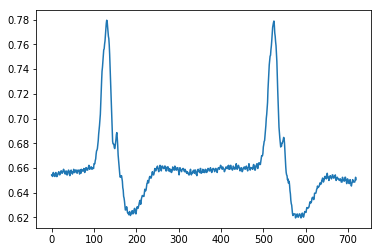

In [6]:
#arr = os.listdir('MLII/1 NSR/')
arr = []
for file in glob.glob('MLII/11 IVR/*.mat'):
    arr.append(file) 
print (len(arr))   

arr = sorted(arr, key=lambda x:x[:])

l = 10
ll = 5
d = np.int(3600/ll)
stride = 1
data = []
for i in range(l):
    #print (arr[i])
    db = scipy.io.loadmat(arr[i])    
    for j in range(ll):
        data.append(db['val'][0, j*d:(j+1)*d])
data = np.array(data).reshape(l*ll, 1, d)    
seq_test = data[:, :, ::stride]
seq_test = seq_test/nr
print (seq_test.shape)  
for i in range(10):
    plt.figure()
    plt.plot(seq_test[i, 0, :])

In [14]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Reshape, Dropout, LSTM, Bidirectional, ConvLSTM2D
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.utils import plot_model

LSTM based GAN

In [8]:
class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (1, self.seq_length)
        self.latent_dim = 100
        self.latent_shape = (1, self.latent_dim)        
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(1, self.latent_dim,))
        generated_seq = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated sequences as input and determines validity
        validity = self.discriminator(generated_seq)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(LSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(512)))
        model.add(Dense(512))
        model.add(Dropout(0.4))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2))        
        model.add(Dense(64))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(32))
        model.add(Dropout(0.4))        
        model.add(LeakyReLU(alpha=0.2)) 
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(LSTM(128, input_shape=self.latent_shape, return_sequences=True))
        model.add(Bidirectional(LSTM(256)))        
        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))        
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))        
        model.summary()
        
        noise = Input(shape=self.latent_shape)
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load and convert the data
        X_train = seq_in

        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Training the model
        for epoch in range(epochs):

            # Select a random batch of note sequences
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]

            noise = np.random.normal(0, 1, (batch_size, 1, self.latent_dim)) 

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            #  Training the Generator
            noise = np.random.normal(0, 1, (batch_size, 1, self.latent_dim)) 
            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
              print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              self.disc_loss.append(d_loss[0])
              self.gen_loss.append(g_loss)
        self.plot_loss()            
            
    def plot_loss(self):
        
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.close()            

In [9]:
gan = GAN(rows=np.int(d/stride))    
gan.train(epochs=2000, batch_size=50, sample_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 512)            2525184   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4198400   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

/home/mabbasloo/miniconda3/envs/RESOURCES/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.696748, acc.: 18.00%] [G loss: 0.694850]
50 [D loss: 0.245529, acc.: 89.00%] [G loss: 2.760950]
100 [D loss: 0.646346, acc.: 56.00%] [G loss: 3.186035]
150 [D loss: 0.603852, acc.: 65.00%] [G loss: 3.014206]
200 [D loss: 0.653788, acc.: 48.00%] [G loss: 2.222845]
250 [D loss: 0.656238, acc.: 39.00%] [G loss: 2.983034]
300 [D loss: 0.639473, acc.: 62.00%] [G loss: 1.973414]
350 [D loss: 0.675247, acc.: 54.00%] [G loss: 1.292847]
400 [D loss: 0.669172, acc.: 61.00%] [G loss: 1.638955]
450 [D loss: 0.657181, acc.: 58.00%] [G loss: 1.538235]
500 [D loss: 0.698633, acc.: 47.00%] [G loss: 2.305802]
550 [D loss: 0.678973, acc.: 52.00%] [G loss: 1.277369]
600 [D loss: 0.675912, acc.: 54.00%] [G loss: 1.544447]
650 [D loss: 0.650311, acc.: 58.00%] [G loss: 0.982176]
700 [D loss: 0.668806, acc.: 57.00%] [G loss: 1.531974]
750 [D loss: 0.692305, acc.: 53.00%] [G loss: 1.119612]
800 [D loss: 0.683946, acc.: 53.00%] [G loss: 0.933449]
850 [D loss: 0.673178, acc.: 52.00%] [G loss: 1.533

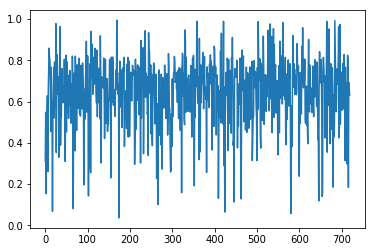

In [11]:
noise = np.random.normal(0, 1, (1, 1, gan.latent_dim))
gen_seqs = gan.generator.predict(noise).reshape(np.int(d/stride))
plt.figure()
plt.plot(gen_seqs)